In [1]:
using CairoMakie
using Oceananigans
using Printf

In [2]:
setname = "U250N100Lz100g100"
include("../parameters.jl")
pm = getproperty(SimParams(), Symbol(setname))

pm = merge(pm, (; Tanθ = sqrt((pm.σ^2 - pm.f^2)/(pm.Ñ^2-pm.σ^2)),
                Tanα = pm.γ * sqrt((pm.σ^2 - pm.f^2)/(pm.Ñ^2-pm.σ^2)),
                nz = round(Int,pm.Lz/2),
                m = -π/pm.Lz,
                l = sqrt(((π/pm.Lz)^2 * (pm.f^2 - pm.σ^2)) / (pm.σ^2 - pm.Ñ^2)),
                Tf = 2*π/pm.f, 
                Tσ = 2*π/pm.σ))

const gausT_center = 895                                 # gaussian paramereters for curved "corner" of slope
const gausT_width = 180
const ySlopeSame = 1336.6                           # point where planar and curved corner math up the best

ΔySlopeSame = 0


@inline heaviside(X) = ifelse(X < 0, 0., 1.) # heaviside returns 1 if x >= 0
# exponential gaussian for curved corner
@inline expcurve(y, ystar, smo) = -pm.Lz + pm.Lz * exp( - (y - ystar)^2 / (2*smo^2))
# planar slope line
@inline linslope(y) = -pm.Tanα * y
# combining the 2 with heaviside split at ySlopeSame
@inline curvedslope(y) = linslope(y) + (-linslope(y) + expcurve(y, gausT_center-ΔySlopeSame, gausT_width)) * heaviside(y-ySlopeSame)

curvedslope (generic function with 1 method)

In [3]:
xc = 2:16:152
yc = 2:16:5500
zc = -498:4:0

xv = xc
yv = 0:16:5500
zv = zc

-498:4:-2

In [4]:
v = [ifelse(z>curvedslope(y), sin(z*y/1000)*0.1, 0.0) for x in xv, y in yv, z in zv];
b = [ifelse(z>curvedslope(y), z*(3.5*1e-3)^2,0.0) for x in xc, y in yc, z in zc];
c = [ifelse(z>curvedslope(y), abs(sin(z*y/1000)*1e-2),0.0) for x in xc, y in yc, z in zc];

In [205]:
interest_idx1 = [round(Int,(pm.Tσ*2.1)/600), round(Int,(pm.Tσ*2.3)/600), round(Int,(pm.Tσ*2.5)/600)]
interest_idx2 = [round(Int,(pm.Tσ*3.0)/600), round(Int,(pm.Tσ*3.1)/600), round(Int,(pm.Tσ*3.3)/600)]
interest_idx3 = [round(Int,(pm.Tσ*3.4)/600), round(Int,(pm.Tσ*3.5)/600), round(Int,(pm.Tσ*3.7)/600)]

interest_idx = [interest_idx1, interest_idx2, interest_idx3]
tims = interest_idx.* 600.0
wavs = tims./ pm.Tσ
wavs[3]

3-element Vector{Float64}:
 3.367242618424606
 3.504681092646018
 3.710838803978137

In [8]:
interest_idx1 = [round(Int,(pm.Tσ*2.1)/600), round(Int,(pm.Tσ*2.3)/600), round(Int,(pm.Tσ*2.5)/600)]

interest_idx3 = [round(Int,(pm.Tσ*3.0)/600), round(Int,(pm.Tσ*3.2)/600), round(Int,(pm.Tσ*3.4)/600)]
interest_idx4 = [round(Int,(pm.Tσ*3.5)/600), round(Int,(pm.Tσ*3.7)/600), round(Int,(pm.Tσ*3.9)/600)]

interest_idxb = [interest_idx3, interest_idx4]
tims = interest_idxb.* 600.0
timsa = interest_idx1 .* 600
wavs = tims./ pm.Tσ
wavsa = timsa ./ pm.Tσ

3-element Vector{Float64}:
 2.1302963504318932
 2.267734824653306
 2.4738925359854247

In [7]:
land = curvedslope.(yc) ;
xlocat = 5

5

In [54]:
f1 = Figure(resolution = (1800, 600), fontsize=26)
ga = f1[1:2, 1] = GridLayout()
gab1 = f1[1, 2] = GridLayout()
gab2 = f1[2, 2] = GridLayout()        

axv1 = Axis(ga[1, 1])
axv2 = Axis(ga[1, 2])
axc2 = Axis(ga[2, 2])
axv3 = Axis(ga[1, 3])
axc3 = Axis(ga[2, 3])
axc1 = Axis(ga[2, 1], ylabel = "z [m]", xlabel = "y [m]")

axc1.xticks = 500:1000:1500
axc2.xticks = 500:1000:1500
axc3.xticks = 500:1000:1500

limits!(axv1, 0, 2000, -450, 0)
limits!(axc1, 0, 2000, -450, 0)
limits!(axv2, 0, 2000, -450, 0)
limits!(axc2, 0, 2000, -450, 0)
limits!(axv3, 0, 2000, -450, 0)
limits!(axc3, 0, 2000, -450, 0)

linkaxes!(axv1, axv2, axv3, axc1, axc2, axc3)

axv = [axv1, axv2, axv3]
axc = [axc1, axc2, axc3]

axv1.yticks = [-250, 0]
axc1.yticks = [-250, 0]

time_pre = "t = "
time_post = " Tσ"

#display(f1)

" Tσ"

In [55]:
# for each time
for (p,j) in enumerate(interest_idx1)

    # get the data
    vi = v[xlocat, :, :]
    bi = b[xlocat, :, :]
    ci = log10.(clamp.(c[xlocat, :, :],1e-8,1))

    phaselabel = time_pre * @sprintf("%0.1f", wavsa[p]) * time_post

    # create the heatmaps
    global hmv = heatmap!(axv[p], yv, zv, vi, colormap = :balance, colorrange = (-pm.U₀, pm.U₀))
    contour!(axv[p], yc, zc, bi, color = :black, lw = 6, levels = -0.006:0.001:0, alpha = 0.5)
    lines!(axv[p], yc, land, color=:black, lw = 4)
    text!(axv[p],Point.(50, -400), text = phaselabel, align = (:left, :center), color = :black, 
    font = :bold, fontsize = 26)

    global hmc = heatmap!(axc[p], yc, zc, ci, colormap= :thermal, colorrange = (-4, 0),)
    contour!(axc[p], yc, zc, bi, color = :white, lw = 6, levels = -0.006:0.001:0, alpha = 0.5)
    lines!(axc[p], yc, land, color=:black, lw = 4)
end
#display(f1)

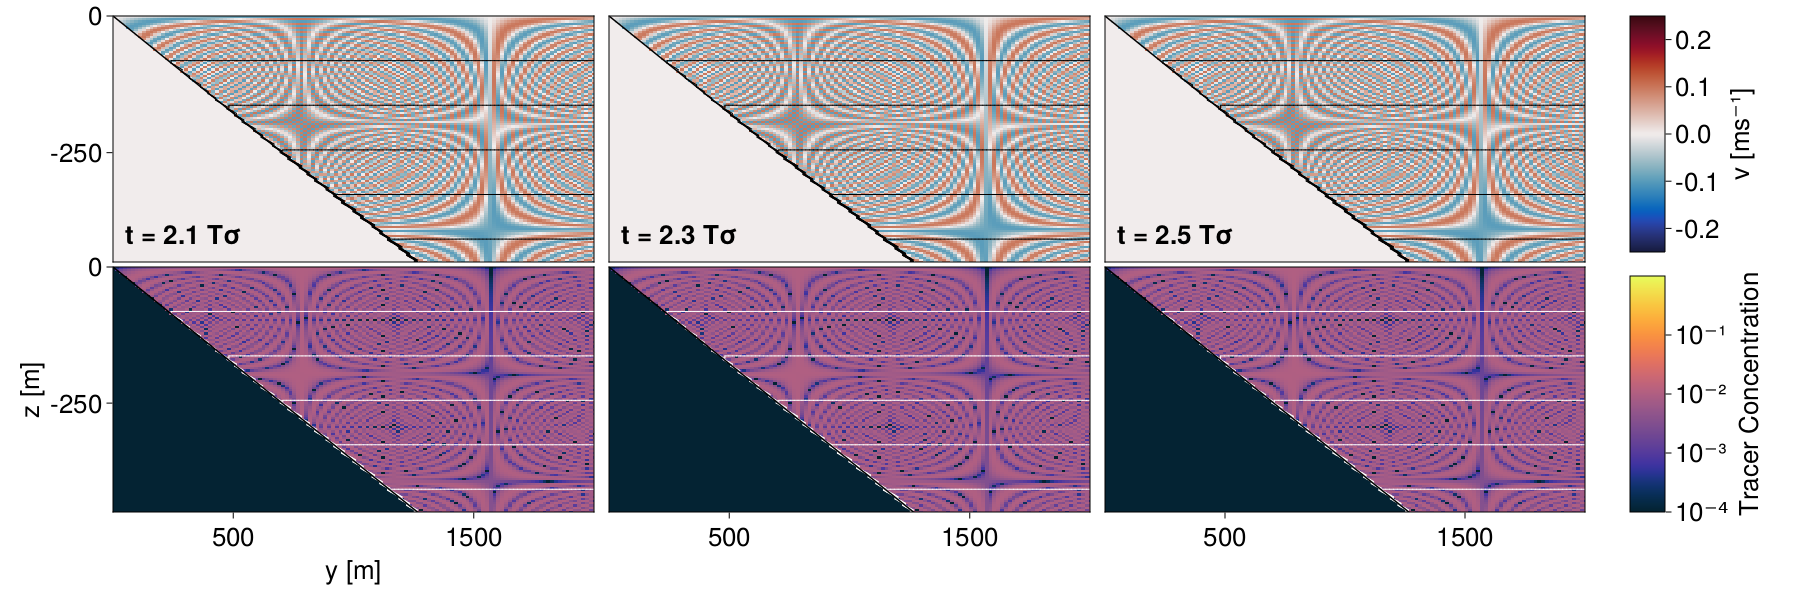

CairoMakie.Screen{IMAGE}


In [56]:
# get rid of the inner values
hidedecorations!(axv2)
hidedecorations!(axv3)
hidexdecorations!(axv1)
hideydecorations!(axc2)
hideydecorations!(axc3)

colgap!(ga, 15)
rowgap!(ga, 5)

# create colorbars the size of the whole data set
cb1 = Colorbar(gab1[1,1], hmv, ticks = (-0.2:.1:0.2), size =35, label = "v [ms⁻¹]")
cb2 = Colorbar(gab2[1,1], hmc, ticks = (-4:1:-1, ["10⁻⁴", "10⁻³", "10⁻²", "10⁻¹"] ), 
        size = 35, label = "Tracer Concentration")

# making colorbars take up less space
colsize!(f1.layout, 2, Relative(0.05))
#colsize!(f1.layout, 3, Relative(0.05))    
display(f1)

In [60]:
f = Figure(resolution = (1600, 700), fontsize=26)
gc = f[1, 1] = GridLayout()
gd = f[2, 1] = GridLayout()
gplots = [gc, gd]

gcb1 = f[:, 2] = GridLayout()
gcb2 = f[:, 3] = GridLayout()        

for (i,g) in enumerate(gplots)
    @info "$i/2 graphs"
    ##################################
    #
    # z  v1(1,1)    v2(1,2)    v3(1,3) (bar)
    # z  c1(2,1)    c2(2,2)    c3(2,3) (bar)
    #      y           y           y
    ##################################

    # set up axes and axes labels
    axv1 = Axis(g[1, 1])

    axv2 = Axis(g[1, 2])
    axc2 = Axis(g[2, 2])

    axv3 = Axis(g[1, 3])
    axc3 = Axis(g[2, 3])


    if g==gd
        axc1 = Axis(g[2, 1], ylabel = "z [m]", xlabel = "y [m]")

        axc1.xticks = 500:1000:1500
        axc2.xticks = 500:1000:1500
        axc3.xticks = 500:1000:1500

    else
        axc1 = Axis(g[2, 1])
    end

    # cut limits of axes to specific size

    limits!(axv1, 0, 2000, -450, 0)
    limits!(axc1, 0, 2000, -450, 0)
    limits!(axv2, 0, 2000, -450, 0)
    limits!(axc2, 0, 2000, -450, 0)
    limits!(axv3, 0, 2000, -450, 0)
    limits!(axc3, 0, 2000, -450, 0)

    linkaxes!(axv1, axv2, axv3, axc1, axc2, axc3)

    axv = [axv1, axv2, axv3]
    axc = [axc1, axc2, axc3]

    axv1.yticks = [-250, 0]
    axc1.yticks = [-250, 0]

    time_pre = "t = "
    time_post = " Tσ"

    # for each time
    for (p,j) in enumerate(interest_idxb[i])

         # get the data
        vi = v[xlocat, :, :]
        bi = b[xlocat, :, :]
        ci = log10.(clamp.(c[xlocat, :, :],1e-8,1))

        phaselabel = time_pre * @sprintf("%0.1f", wavs[i][p]) * time_post

        # create the heatmaps
        global hmv = heatmap!(axv[p], yv, zv, vi, colormap = :balance, colorrange = (-pm.U₀, pm.U₀))
        contour!(axv[p], yc, zc, bi, color = :black, lw = 6, levels = -0.006:0.001:0, alpha = 0.5)
        lines!(axv[p], yc, land, color=:black, lw = 4)
        text!(axv[p],Point.(50, -400), text = phaselabel, align = (:left, :center), color = :black, 
        font = :bold, fontsize = 26)

        global hmc = heatmap!(axc[p], yc, zc, ci, colormap= :thermal, colorrange = (-4, 0),)
        contour!(axc[p], yc, zc, bi, color = :white, lw = 6, levels = -0.006:0.001:0, alpha = 0.5)
        lines!(axc[p], yc, land, color=:black, lw = 4)

    end

    # get rid of the inner values
    hidedecorations!(axv2)
    hidedecorations!(axv3)
    hidexdecorations!(axv1)

    if g == gd
        hideydecorations!(axc2)
        hideydecorations!(axc3)
    else
        hidedecorations!(axc2)
        hidedecorations!(axc3)
        hidexdecorations!(axc1)
    end

    colgap!(g, 15)
    rowgap!(g, 5)
end


[ Info: 1/2 graphs
[ Info: 2/2 graphs


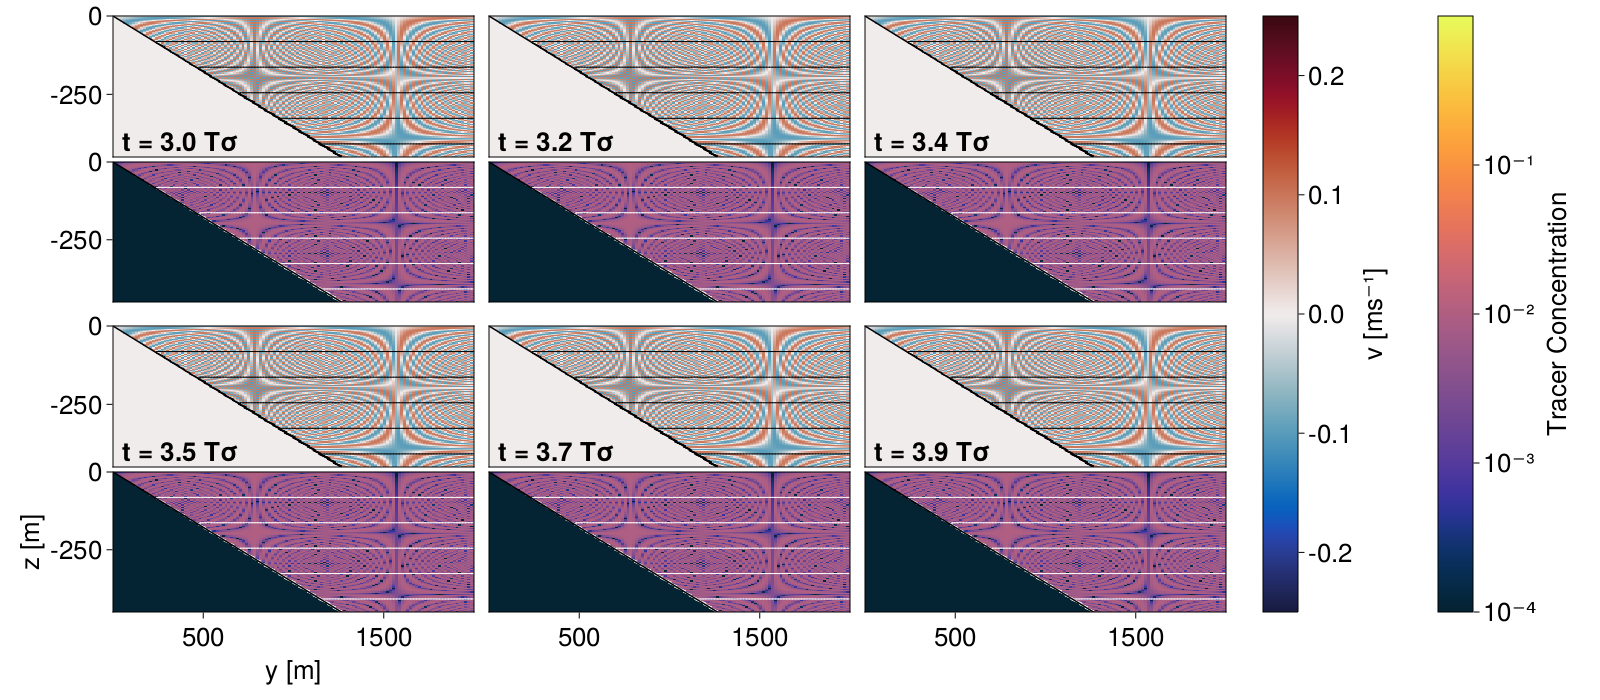

CairoMakie.Screen{IMAGE}


In [61]:

 # create colorbars the size of the whole data set
cb1 = Colorbar(gcb1[1,1], hmv, ticks = (-0.2:.1:0.2), size =35, label = "v [ms⁻¹]")
cb2 = Colorbar(gcb2[1,1], hmc, ticks = (-4:1:-1, ["10⁻⁴", "10⁻³", "10⁻²", "10⁻¹"] ), 
        size = 35, label = "Tracer Concentration")

# making colorbars take up less space
colsize!(f.layout, 2, Relative(0.05))
colsize!(f.layout, 3, Relative(0.05))    

display(f)

In [222]:
f = Figure(resolution = (1700, 900), fontsize=26)
ga = f[1, 1] = GridLayout()
gb = f[2, 1] = GridLayout()
gc = f[3, 1] = GridLayout()
gplots = [ga, gb, gc]

gcb1 = f[:, 2] = GridLayout()
gcb2 = f[:, 3] = GridLayout()        

for (i,g) in enumerate(gplots)
    @info "$i/3 graphs"
    ##################################
    #
    # z  v1(1,1)    v2(1,2)    v3(1,3) (bar)
    # z  c1(2,1)    c2(2,2)    c3(2,3) (bar)
    #      y           y           y
    ##################################

    # set up axes and axes labels
    axv1 = Axis(g[1, 1])

    axv2 = Axis(g[1, 2])
    axc2 = Axis(g[2, 2])

    axv3 = Axis(g[1, 3])
    axc3 = Axis(g[2, 3])


    if g==gc
        axc1 = Axis(g[2, 1], ylabel = "z [m]", xlabel = "y [m]")

        axc1.xticks = 500:1000:1500
        axc2.xticks = 500:1000:1500
        axc3.xticks = 500:1000:1500

    else
        axc1 = Axis(g[2, 1])
    end

    # cut limits of axes to specific size

    limits!(axv1, 0, 2000, -450, 0)
    limits!(axc1, 0, 2000, -450, 0)
    limits!(axv2, 0, 2000, -450, 0)
    limits!(axc2, 0, 2000, -450, 0)
    limits!(axv3, 0, 2000, -450, 0)
    limits!(axc3, 0, 2000, -450, 0)

    linkaxes!(axv1, axv2, axv3, axc1, axc2, axc3)

    axv = [axv1, axv2, axv3]
    axc = [axc1, axc2, axc3]

    axv1.yticks = [-250, 0]
    axc1.yticks = [-250, 0]

    # for each time
    for p in 1:3
        
        vi = v[xlocat, :, :]
        bi = b[xlocat, :, :]
        ci = log10.(clamp.(c[xlocat, :, :],1e-8,1))

        phaselabel = time_pre * @sprintf("%0.1f", wavs[i][p]) * time_post
        
        # create the heatmaps
        global hmv = heatmap!(axv[p], yv, zv, vi, colormap = :balance, colorrange = (-pm.U₀, pm.U₀))
        contour!(axv[p], yc, zc, bi, color = :black, lw = 6, levels = -0.006:0.001:0, alpha = 0.5)
        lines!(axv[p], yc, land, color=:black, lw = 4)
        text!(axv[p],Point.(50, -400), text = phaselabel, align = (:left, :center), color = :black, 
         font = :bold, fontsize = 26)


        global hmc = heatmap!(axc[p], yc, zc, ci, colormap= :thermal, colorrange = (-4, 0),)
        contour!(axc[p], yc, zc, bi, color = :white, lw = 6, levels = -0.006:0.001:0, alpha = 0.5)
        lines!(axc[p], yc, land, color=:black, lw = 4)
    end

    # get rid of the inner values
    hidedecorations!(axv2)
    hidedecorations!(axv3)
    hidexdecorations!(axv1)

    if g == gc
        hideydecorations!(axc2)
        hideydecorations!(axc3)
    else
        hidedecorations!(axc2)
        hidedecorations!(axc3)
        hidexdecorations!(axc1)
    end

    colgap!(g, 15)
    rowgap!(g, 5)
        
    #for (idx, wave) in enumerate(wavs[i])
    #    phaselabel = time_pre * @sprintf("%0.1f", wave) * time_post
    #    #Label(g[1, idx, Top()], phaselabel,
    #    #    valign = :bottom, font = :bold, padding = (0, 0, 5, 0))
    #end
    
end

[ Info: 1/3 graphs
[ Info: 2/3 graphs
[ Info: 3/3 graphs


In [225]:
# create colorbars the size of the whole data set
cb1 = Colorbar(gcb1[1,1], hmv, ticks = (-0.2:.1:0.2), size = 35)
cb2 = Colorbar(gcb2[1,1], hmc, ticks = (-4:1:-1, ["10⁻⁴", "10⁻³", "10⁻²", "10⁻¹"] ),size = 35)
#Colorbar(f[end+1,:], hmv, ticks = (-0.2:.1:0.2), label = "v, velocity", vertical = false)
#Colorbar(f[end+1,:], hmc, ticks = (-4:1:-1, ["10⁻⁴", "10⁻³", "10⁻²", "10⁻¹"] ), label = "Tracer Concentration", 
  #  vertical = false, flipaxis = false)
Label(gcb1[1, 1, Top()], "v [m²s⁻¹]", valign = :bottom, font = :bold,
    padding = (0, 0, 5, 0), justification = :center)
Label(gcb2[1, 1, Top()], "Tracer", valign = :bottom, font = :bold, 
    padding = (0, 0, 5, 0), justification = :center)
#cb1.alignmode = Mixed(right = 0)
#cb2.alignmode = Mixed(right = 0)
colsize!(f.layout, 2, Relative(0.04))
colsize!(f.layout, 3, Relative(0.04))

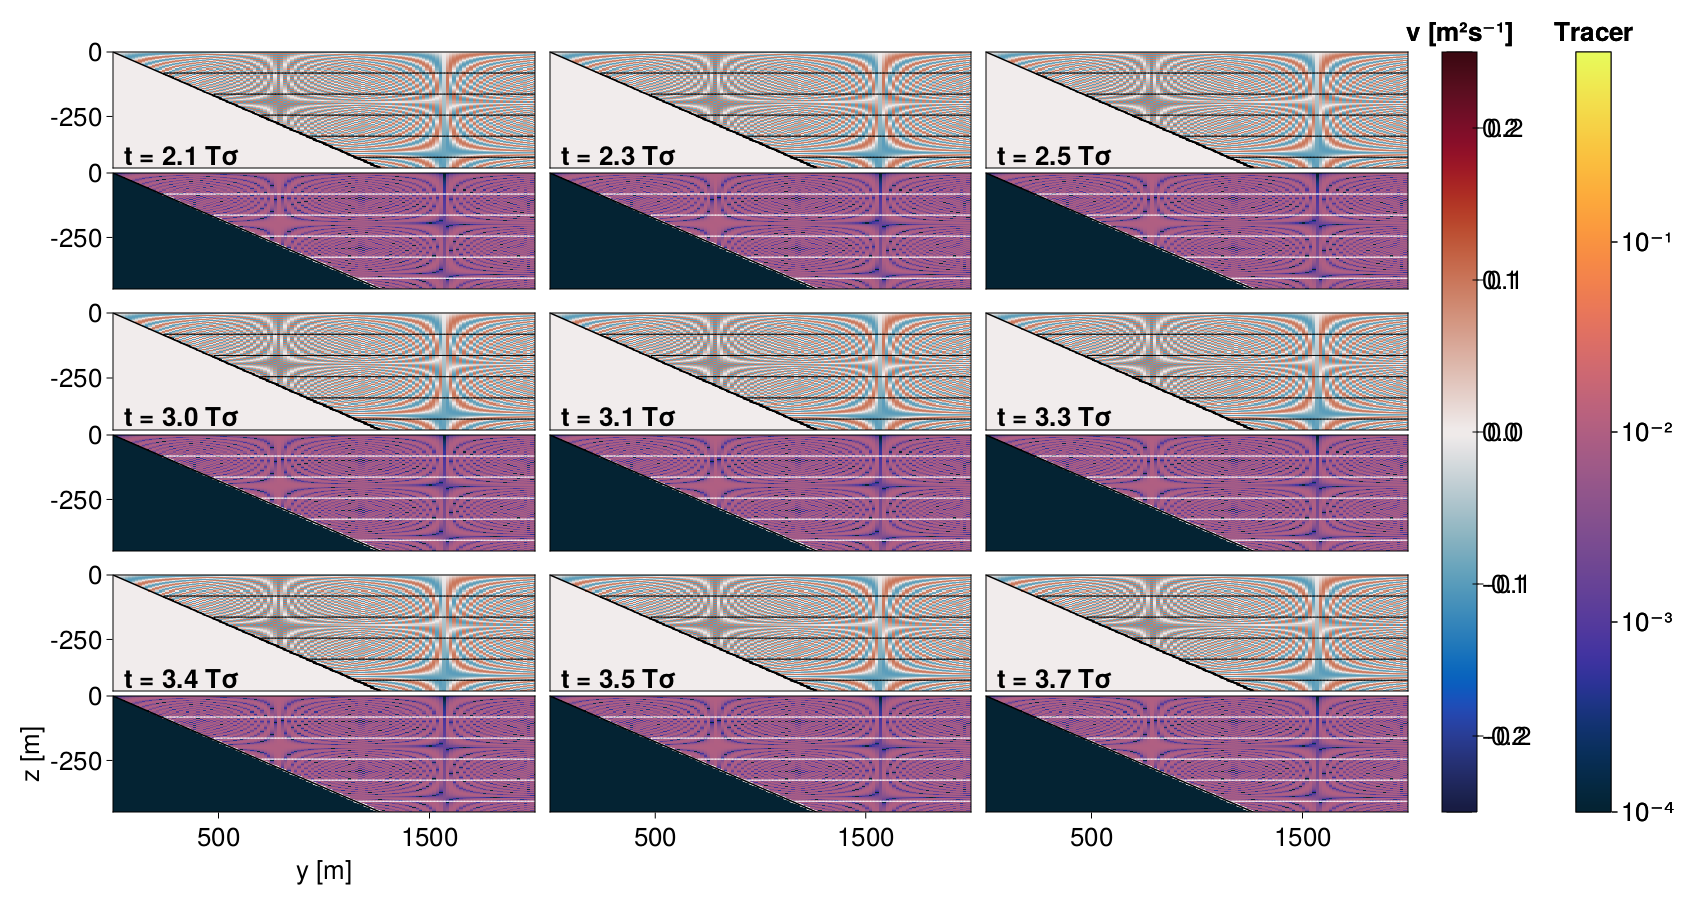

CairoMakie.Screen{IMAGE}


In [226]:
display(f)

In [91]:
rowsize!(f.layout, 4, Relative(0.02))
rowsize!(f.layout, 5, Relative(0.02))
display(f)

LoadError: Can't set size of invalid row 4.

2.267734824653306

In [33]:
f[1, 4]

GridPosition(GridLayout[3, 4] (7 children), GridLayoutBase.Span(1:1, 4:4), GridLayoutBase.Inner())

In [117]:
methods(text)

# 2 methods for generic function "text":
[1] text() in MakieCore at /Users/vicwhit/.julia/packages/MakieCore/6sckc/src/recipes.jl:173
[2] text(args...; attributes...) in MakieCore at /Users/vicwhit/.julia/packages/MakieCore/6sckc/src/recipes.jl:33